In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import imageio
%matplotlib inline

In [2]:
from tqdm import tqdm_notebook, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
import random
import numpy as np

import sys
import os
from optparse import OptionParser

import torch.backends.cudnn as cudnn
from torch import optim
import time

In [3]:
!nvidia-smi

Sat May 16 17:07:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 21%   25C    P8     8W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import unet
from unet import UNet2D, UNet3D
import torchio

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



### 1. Сегментируем 3D

1. надо резать на 64 скорее всего, тогда из каждого получится 64*3 = 192
(но! надо по сайтам смотреть, как их центрировать)
2. кажется норм таки идея начать с 2D
3.

In [196]:
import sys
sys.path.append("..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data_loader import MriSegmentation

  0%|          | 0/15 [00:00<?, ?it/s]

Assembling data for:  pirogov  sample.


/gpfs/data/opt/python-3.6.8/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


Dataset size: 15
Labels distribution: (array([1]), array([15]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


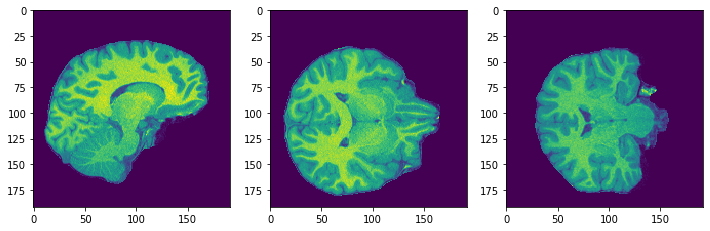

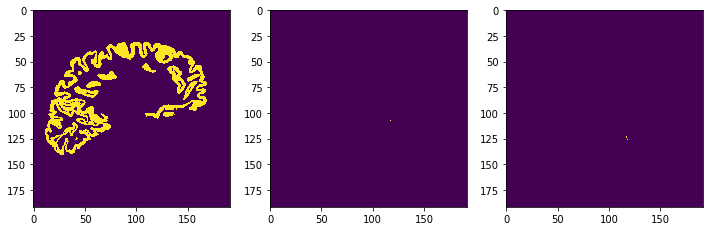

In [202]:
pirogov_data = MriSegmentation(sample='pirogov', prefix = 'fcd', mask='seg', 
                         coord_min=(20,20,20,), img_shape=(192, 192, 192,),
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

print("Dataset size: {}".format(len(pirogov_data)))
print("Labels distribution: {}\n".format(np.unique(pirogov_data.target, return_counts=True)))
img, seg = pirogov_data[3]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img)
plot_central_cuts(seg)

In [126]:
# дроп, потом реиндекс

# не похожи fcd  9, 11, 12, 13, 14 - глазами все правильно, хз где ошибка = надо проверить умножение

In [ ]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [14]:
from models import unet3d

In [ ]:
model = models.VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape=la5_dataset.img_shape, dropout=0., n_fc_units=128,
                             n_flatten_units=23040)

def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=3e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

In [ ]:
def train_net(net,
              epochs=5,
              batch_size=2,
              lr=0.1,
              val_percent=0.05,
              save_cp=False,
              gpu=True,
              img_scale=0.5):

    dir_img = 'BBBC018_v1_images-fixed/train/'
    dir_mask = 'BBBC018_v1_outlines/train/'
    dir_checkpoint = 'checkpoints/'

    ids = get_ids(dir_img)
    ids = split_ids(ids)

    iddataset = split_train_val(ids, val_percent)

    print('''
    Starting training:
        Epochs: {}
        Batch size: {}
        Learning rate: {}
        Training size: {}
        Validation size: {}
        Checkpoints: {}
        CUDA: {}
    '''.format(epochs, batch_size, lr, len(iddataset['train']),
               len(iddataset['val']), str(save_cp), str(gpu)))

    N_train = len(iddataset['train'])

    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = optim.SGD(net.parameters(), lr=lr)

    #criterion = nn.BCELoss()

    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()

        # reset the generators
        train = get_imgs_and_masks(iddataset['train'], dir_img, dir_mask, img_scale)
        val = get_imgs_and_masks(iddataset['val'], dir_img, dir_mask, img_scale)

        epoch_loss = 0

        for i, b in enumerate(batch(train, batch_size)):
            imgs = np.array([i[0] for i in b]).astype(np.float32)
            true_masks = np.array([i[1] for i in b])

            imgs = torch.from_numpy(imgs)
            true_masks = torch.from_numpy(true_masks)

            if gpu:
                imgs = imgs.to(device)
                true_masks = true_masks.to(device)

            masks_pred = net(imgs)
            masks_probs_flat = masks_pred.view(-1)

            true_masks_flat = true_masks.view(-1)
            
            # print(masks_probs_flat)
            # loss = criterion(masks_probs_flat, true_masks_flat)
            loss = - 2 * (masks_probs_flat * true_masks_flat).sum() / (true_masks_flat.pow(2).sum() + masks_probs_flat.pow(2).sum())
            epoch_loss += loss.item()

            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch finished ! Loss: {}'.format(epoch_loss / i))

        if 1:
            val_dice = eval_net(net, val, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))

        if save_cp:
            torch.save(net.state_dict(),
                       dir_checkpoint + 'CP{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))